In [1]:
from util import *
import matplotlib as mpl
from colorsys import hls_to_rgb as hls2rgb

import pickle
from itertools import product
import os, shutil

df = loadDF()
total_difference =np.sum(np.abs(df['pstep'].values - df['wstep'].values))

df['30min'] = df['first'].dt.hour + (df['first'].dt.minute//30)/2
coverage = getBoutInfo(df, ['uid', 'date', 'weekday','30min'])

columns = []
for metric in ['step_ratio', 'step','count_ratio', 'count']:
    for btype in ['b','p','w']:
        columns.append(btype+metric)
columns.append('totalstep')
columns.append('totalcount')

ncolors = 13
color_match = [
    (0, hls2rgb(0,1,0)),
    (1/(ncolors-1), hls2rgb(120/360,80/100,57/100)),
    (2/(ncolors-1), hls2rgb(205/360,90/100,70/100)), 
    (3/(ncolors-1), hls2rgb(28/360,90/100,100/100)), 
    (4/(ncolors-1), hls2rgb(0/360,80/100,0/100)), 

    (5/(ncolors-1), hls2rgb(120/360,60/100,57/100)),
    (6/(ncolors-1), hls2rgb(205/360,70/100,70/100)), 
    (7/(ncolors-1), hls2rgb(28/360,70/100,100/100)), 
    (8/(ncolors-1), hls2rgb(0/360,40/100,0/100)),
    
    (9/(ncolors-1), hls2rgb(120/360,40/100,57/100)),
    (10/(ncolors-1), hls2rgb(205/360,50/100,70/100)), 
    (11/(ncolors-1), hls2rgb(28/360,50/100,100/100)), 
    (12/(ncolors-1), hls2rgb(0/360,0/100,0/100)),
    ]
descriptions = [
    "inactive", 
    *[" ".join([a,b]) for a, b in list(product(["small","middle","large"],["both","phone","watch","not-dominant"]))]]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', color_match, len(color_match))
patches = []
import matplotlib.patches as mpatches
for i in range(ncolors):
    patches.append(mpatches.Patch(color = color_match[i][1], label = descriptions[i]))

def get_color(row):
    # White
    if row[columns.index('totalstep')] ==0:
        return 0
    else:
        level = None
        if row[columns.index('totalstep')] < 50:
            level = 0
        elif row[columns.index('totalstep')] < 250:
            level =1
        else:
            level = 2
        if row[columns.index('bstep_ratio')] >.95:
            return level*4+ 1
        # Phone
        elif row[columns.index('pstep_ratio')] >.95:
            return level*4+ 2
        # Watch
        elif row[columns.index('wstep_ratio')] >.95:
            return level*4+ 3
        else:
            return level*4+ 4

77 602
204 0.3388704318936877
0.031043269422374235 0.048683440944686816
5533.218438538206 4582.25
75 668
141 0.21107784431137724
0.04837645865953941 0.05826852895405451
8755.366017964072 7562.5
58 421
65 0.1543942992874109
0.02455176098323374 0.05727182389724842
11503.53325415677 10380.5
52 296
137 0.46283783783783783
0.10971427189965545 0.01027672568027095
5130.8699324324325 4068.5
28 154
48 0.3116883116883117
0.14452702048499372 0.0012239796608976736
8559.724025974027 7125.0
55 364
100 0.27472527472527475
0.010969380641397896 0.092463363489406
6922.945054945055 6445.75
53 336
137 0.40773809523809523
0.023771439541065673 0.02972869109096717
2666.407738095238 1003.25


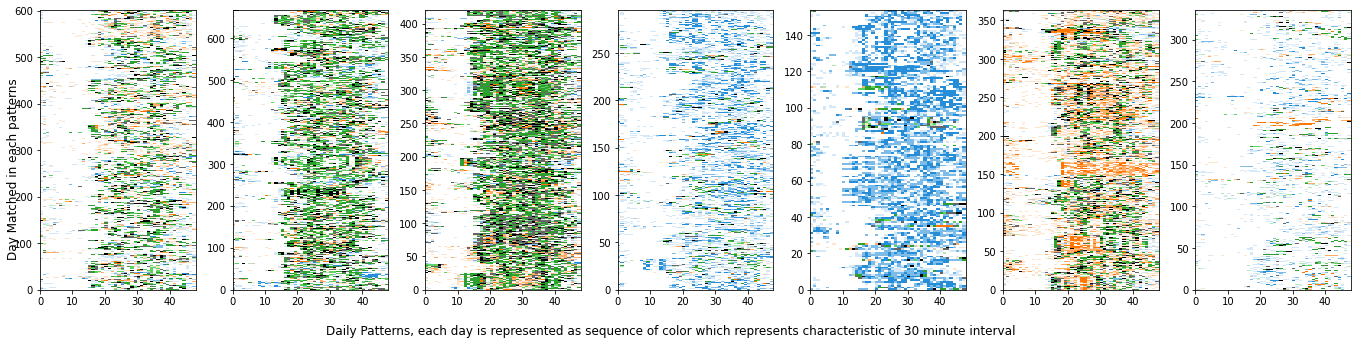

In [2]:
from sklearn.cluster import KMeans
coverage['color'] = [get_color(row) for row in coverage.values]
coverage_plot = coverage[['color']].unstack(level = 3, fill_value= 0)

X = []
for idx, day in enumerate(coverage_plot.values):
    X.append([np.sum((day == 9)|(day == 5)|(day == 12)|(day == 8)),np.sum((day == 10)|(day == 6)),np.sum((day == 11)|(day == 7)),np.sum((day==4)|(day==0)|(day==1)),np.sum((day==2)),np.sum((day==3))])

X = np.array(X)
X = X/48

K = 7
kmeans = KMeans(n_clusters = K, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
labels = {0:1, 1:2,2:4, 3:6,4:5, 5:3,6:0}
pred_y = np.array([labels[val] for val in pred_y])
coverage_plot['group'] = pred_y
coverage_plot.columns = [*np.arange(48),'group']
coverage_plot = coverage_plot.reset_index()
coverage = getBoutInfo(df, ['uid', 'date'])
fig, axes = plt.subplots(nrows = 1, ncols = K, figsize= (3.2*(K-1),4.8))
for idx,ax in enumerate(axes.flatten()):
    if idx <K:
        label = idx
        print(len(set(coverage_plot.query('group == @label')['uid'])), coverage_plot.query('group == @label').shape[0])
        print(coverage_plot.query('group == @label').query('weekday >= 5').shape[0], coverage_plot.query('group == @label').query('weekday >= 5').shape[0]/coverage_plot.query('group == @label').shape[0])
        print(coverage[pred_y == label]['pstep'].sum()/total_difference, coverage[pred_y == label]['wstep'].sum()/total_difference)
        # print([round(ratio, 2) for ratio in kmeans.cluster_centers_[label]])
        print(coverage[pred_y == label]['totalstep'].mean(),coverage[pred_y == label]['totalstep'].median())
        ax.pcolor(coverage_plot.values[:,3:-1].astype(dtype = np.uint8)[pred_y == label], cmap = cmap)
fig.supxlabel("Daily Patterns, each day is represented as sequence of color which represents characteristic of 30 minute interval")
fig.supylabel("Day Matched in each patterns")
plt.tight_layout()

Text(0.02, 0.5, 'Step count')

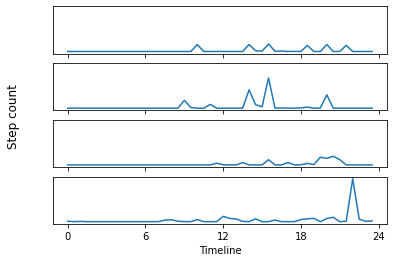

In [3]:
tmp = getBoutInfo(df,['uid','date','30min'])['totalstep'].unstack(level = 2, fill_value= 0)
fig, axes = plt.subplots(nrows = 4, ncols = 1, sharex = True, sharey= True)

axes[0].plot(np.arange(48),tmp.iloc[0].values)

axes[1].plot(np.arange(48),tmp.iloc[4].values)
axes[2].plot(np.arange(48),tmp.iloc[3].values)
axes[3].plot(np.arange(48),tmp.iloc[27].values)

axes[-1].set_xticks(np.arange(0,50,12))
axes[-1].set_xticklabels([0,6,12,18,24])
axes[-1].set_xlabel("Timeline")
axes[-1].set_yticks([])
fig.supylabel("Step count")


In [4]:
survey = pd.read_csv(os.path.join(data_dir, "survey.csv"), index_col = False, header = 0) 

for i, (usage, number) in enumerate([('DAT','Q3.1'),('Notf','Q3.2'),('Exercise','Q3.3'),('Sleep', 'Q3.4')]):
    users = survey[survey[number] == 1.0]['UID'].values
    print(usage, len(users))
    coverage_plot[usage] = [1 if uid in users else 0 for uid in coverage_plot['uid'].values]
users = survey.query('Q4 != "Enter" and VER == 2')['UID'].values
print('NotEnt', len(users))
coverage_plot['NotEnt'] = [1 if uid in users else 0 for uid in coverage_plot['uid'].values]


DAT 19
Notf 36
Exercise 26
Sleep 13
NotEnt 10


In [5]:
survey.query('VER == 2')['UID'].values

array(['P03', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P12', 'P14',
       'P17', 'P19', 'P22', 'P24', 'P26', 'P27', 'P28', 'P29', 'P31',
       'P32', 'P35', 'P36', 'P37', 'P40', 'P41', 'P42', 'P43', 'P44',
       'P46', 'P47', 'P48', 'P49', 'P50', 'P51', 'P54', 'P59', 'P61',
       'P64', 'P65', 'P66', 'P68', 'P71', 'P72', 'P73', 'P76', 'P77',
       'P79', 'P81', 'P85', 'P88', 'P89', 'P94', 'P95', 'P96', 'P98'],
      dtype=object)

In [6]:
n_pattern = 7
ratios = []
for i in range(n_pattern):
    tmp = []
    for usage in ['DAT','Notf','Exercise','Sleep','NotEnt']:
        ratio = coverage_plot.query(f'group == @i and {usage} == 1')    
        tmp.append(ratio.shape[0])
    tmp.append(coverage_plot.query('group == @i').shape[0])
    ratios.append(tmp)
ratios = np.array(ratios)
ratios = ratios / ratios.sum(axis = 0).reshape(1,-1)

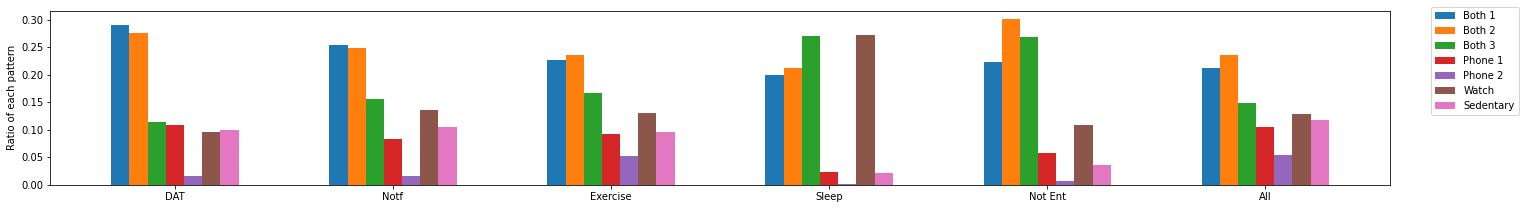

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4.8*5,3.2))
labels=['Both 1','Both 2','Both 3','Phone 1','Phone 2','Watch','Sedentary']
for i in range(n_pattern):
    ax.bar(x = np.arange(i/3, (n_pattern+1)/2*6, (n_pattern+1)/2), height = ratios[i], label =labels[i], width = 1/3)
ax.set_xticks(np.arange(1, 25,4))
ax.set_xticklabels(['DAT','Notf','Exercise','Sleep','Not Ent','All'])
ax.set_ylabel("Ratio of each pattern")
leg = ax.legend(loc = 'upper right',bbox_to_anchor=(1.1, 1.05))

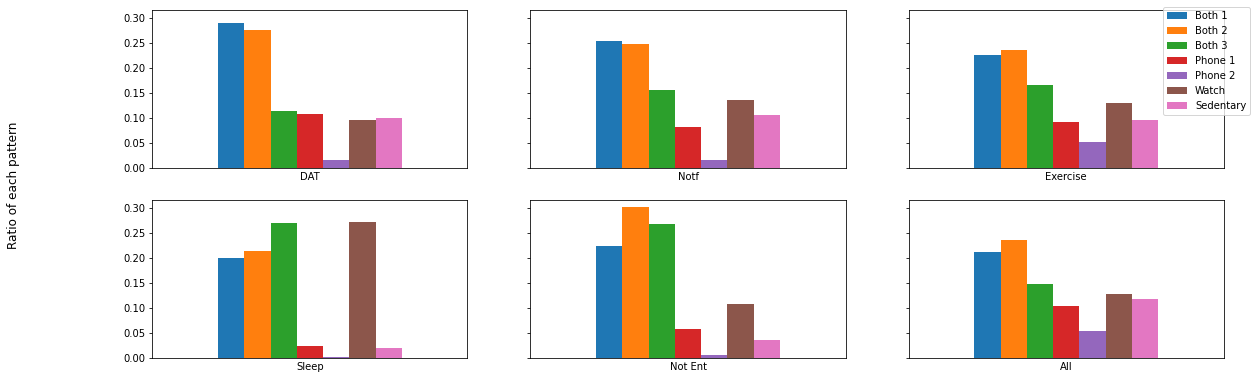

In [25]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (4.8*4,3.2*2), sharex= True, sharey= True)
axes = axes.flatten()
labels=['Both 1','Both 2','Both 3','Phone 1','Phone 2','Watch','Sedentary']
xlabels = ['DAT','Notf','Exercise','Sleep','Not Ent','All']
for idx in range(6):
    for i in range(n_pattern):
        axes[idx].bar(x = np.arange(i/3, (n_pattern+1)/2*1, (n_pattern+1)/2), height = ratios[i][idx], label =labels[i], width = 1/3)
        axes[idx].set_xlabel(xlabels[idx])
axes[-1].set_xticks([])
axes[-1].set_xlim([-1,3])
# axes[-1].set_ylim([0,.5])
fig.supylabel("Ratio of each pattern")
axes[2].legend(loc = 'upper right',bbox_to_anchor=(1.1, 1.05))
# plt.tight_layout()

In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv("Data/survey.csv")
df = df.query("VALID !=0")
x= df['Gender'].values
np.sum(x=='M')

71